# Belgium Emergency Medical Service Optimization

## 1. Introduction and Data Loading

In this project, we aim to optimize the emergency medical services in Belgium, with a focus on AED (Automated External Defibrillator) placement. We'll analyze intervention data, AED locations, and other emergency resources to improve response times and coverage.



In [2]:

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import KDTree
from shapely.geometry import Point
import os

# Set up paths
base_path = "/Users/Zhuanz/数字游民/mda 项目/mda_project"
data_path = os.path.join(base_path, "data", "processed")
output_path = os.path.join(base_path, "output")

# Ensure output directory exists
os.makedirs(output_path, exist_ok=True)

# Load processed data
data = pd.read_csv(os.path.join(data_path, "processed_interventions.csv"))

# Load Belgium shapefile
belgium_shapefile = gpd.read_file(os.path.join(data_path, "BELGIUM_-_Provinces.geojson"))
belgium_shapefile = belgium_shapefile.to_crs(epsg=4326)

print("Data shape:", data.shape)
print("Columns:", data.columns.tolist())

/var/folders/yf/z4xgk8sn7b99hz2zwwrwyj800000gp/T/ipykernel_25979/3918086632.py:19: DtypeWarning: Columns (1,3,4,5,8,9,10,11,12,13,14,15,19,20,22,23,24,25,26,27,28,29,38,39,40,41,45,46,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,75) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(os.path.join(data_path, "processed_interventions.csv"))


Data shape: (1045549, 76)
Columns: ['mission_id', 'service_name', 'postalcode_permanence', 'cityname_permanence', 'streetname_permanence', 'housenumber_permanence', 'latitude_permanence', 'longitude_permanence', 'permanence_short_name', 'permanence_long_name', 'vector_type', 'eventtype_firstcall', 'eventlevel_firstcall', 'eventtype_trip', 'eventlevel_trip', 'postalcode_intervention', 'cityname_intervention', 'latitude_intervention', 'longitude_intervention', 'province_intervention', 't0', 't1', 't1confirmed', 't2', 't3', 't4', 't5', 't6', 't7', 't9', 'intervention_time_(t1reported)', 'intervention_time_(t1confirmed)', 'waiting_time', 'intervention_duration', 'departure_time_(t1reported)', 'departure_time_(t1confirmed)', 'unavailable_time', 'name_destination_hospital', 'postalcode_destination_hospital', 'cityname_destination_hospital', 'streetname_destination_hospital', 'housenumber_destination_hospital', 'calculated_traveltime_destinatio', 'calculated_distance_destination', 'number_of_

## 2. Data Preprocessing and Geospatial Analysis

We'll prepare our data for geospatial analysis and calculate distances to the nearest emergency resources.

In [4]:

def haversine_distance(lon1, lat1, lon2, lat2):
    """Calculate the great circle distance between two points on the earth"""
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

def assign_province(df, belgium_shapefile):
    """Assign province to each point based on its coordinates"""
    if belgium_shapefile is None or df.empty:
        return df
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")
    joined = gpd.sjoin(gdf, belgium_shapefile, how="left", predicate="within")
    df['province'] = joined['NAME_2']
    return df

# Check data structure
print("Data columns:")
print(data.columns.tolist())
print("\nData types:")
print(data.dtypes)
print("\nFirst few rows:")
print(data.head())

# Find latitude and longitude columns
lat_columns = [col for col in data.columns if 'lat' in col.lower()]
lon_columns = [col for col in data.columns if 'lon' in col.lower()]

if lat_columns and lon_columns:
    print(f"\nFound latitude column: {lat_columns[0]}")
    print(f"Found longitude column: {lon_columns[0]}")
    data = data.rename(columns={lat_columns[0]: 'latitude', lon_columns[0]: 'longitude'})
else:
    print("\nWarning: Could not find latitude and longitude columns.")
    print("Skipping geospatial analysis.")
    
# Preprocess data
if 'latitude' in data.columns and 'longitude' in data.columns:
    data = data.dropna(subset=['latitude', 'longitude'])
    data = assign_province(data, belgium_shapefile)

    # Separate data into different types
    interventions = data[data['intervention'] == 1] if 'intervention' in data.columns else pd.DataFrame()
    aeds = data[data['aed'] == 1] if 'aed' in data.columns else pd.DataFrame()
    ambulances = data[data['ambulance'] == 1] if 'ambulance' in data.columns else pd.DataFrame()
    mugs = data[data['mug'] == 1] if 'mug' in data.columns else pd.DataFrame()
    pits = data[data['pit'] == 1] if 'pit' in data.columns else pd.DataFrame()

    print("\nData subsets:")
    print(f"Interventions: {len(interventions)}")
    print(f"AEDs: {len(aeds)}")
    print(f"Ambulances: {len(ambulances)}")
    print(f"MUGs: {len(mugs)}")
    print(f"PITs: {len(pits)}")

    # Calculate distances to nearest resources for interventions
    if not interventions.empty:
        trees = {}
        for resource_name, resource_data in [('aed', aeds), ('ambulance', ambulances), ('mug', mugs), ('pit', pits)]:
            if not resource_data.empty:
                trees[resource_name] = KDTree(resource_data[['latitude', 'longitude']])

        for resource in trees.keys():
            distances, _ = trees[resource].query(interventions[['latitude', 'longitude']])
            interventions[f'distance_to_{resource}'] = distances

        print("\nInterventions with calculated distances:")
        print(interventions.head())
    else:
        print("\nNo intervention data available for distance calculations.")
else:
    print("Skipping geospatial analysis due to missing coordinate data.")

Data columns:
['mission_id', 'service_name', 'postalcode_permanence', 'cityname_permanence', 'streetname_permanence', 'housenumber_permanence', 'latitude_permanence', 'longitude_permanence', 'permanence_short_name', 'permanence_long_name', 'vector_type', 'eventtype_firstcall', 'eventlevel_firstcall', 'eventtype_trip', 'eventlevel_trip', 'postalcode_intervention', 'cityname_intervention', 'latitude_intervention', 'longitude_intervention', 'province_intervention', 't0', 't1', 't1confirmed', 't2', 't3', 't4', 't5', 't6', 't7', 't9', 'intervention_time_(t1reported)', 'intervention_time_(t1confirmed)', 'waiting_time', 'intervention_duration', 'departure_time_(t1reported)', 'departure_time_(t1confirmed)', 'unavailable_time', 'name_destination_hospital', 'postalcode_destination_hospital', 'cityname_destination_hospital', 'streetname_destination_hospital', 'housenumber_destination_hospital', 'calculated_traveltime_destinatio', 'calculated_distance_destination', 'number_of_transported_persons',

## 3. Visualization and Analysis

Let's visualize our data to gain insights into the distribution of resources and interventions.

In [8]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import KDTree
from shapely.geometry import Point
import os

# Set up paths
base_path = "/Users/Zhuanz/数字游民/mda 项目/mda_project"
processed_data_path = os.path.join(base_path, "data", "processed")

# Function to safely read CSV files
def safe_read_csv(file_path):
    try:
        return pd.read_csv(file_path)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return pd.DataFrame()

# Load processed data
interventions = safe_read_csv(os.path.join(processed_data_path, "processed_interventions.csv"))
total_df = safe_read_csv(os.path.join(processed_data_path, "total_df_preprocessed.csv"))

# If interventions data is empty, try using total_df
if interventions.empty and not total_df.empty:
    interventions = total_df

# Load AED data
aed_total = safe_read_csv(os.path.join(processed_data_path, "aed_total_coordinates.csv"))

# Load Belgium shapefile
belgium_shapefile = gpd.read_file(os.path.join(processed_data_path, "BELGIUM_-_Provinces.geojson"))

# Print data info
print("Interventions data shape:", interventions.shape)
print("AED data shape:", aed_total.shape)
print("Belgium shapefile shape:", belgium_shapefile.shape)

# Print column names
print("\nInterventions columns:")
print(interventions.columns.tolist())
print("\nAED columns:")
print(aed_total.columns.tolist())

# Function to get column name
def get_column_name(df, possible_names):
    for name in possible_names:
        if name in df.columns:
            return name
    return None

# Identify key columns
lat_col = get_column_name(interventions, ['latitude', 'lat'])
lon_col = get_column_name(interventions, ['longitude', 'lon', 'long'])
intervention_col = get_column_name(interventions, ['intervention', 'is_intervention'])
aed_col = get_column_name(interventions, ['aed', 'is_aed'])

if lat_col and lon_col:
    # Plot data
    plt.figure(figsize=(15, 10))
    
    # Plot interventions
    if intervention_col:
        intervention_data = interventions[interventions[intervention_col] == 1]
        plt.scatter(intervention_data[lon_col], intervention_data[lat_col], 
                    alpha=0.5, label='Interventions')
    
    # Plot AEDs
    if aed_col:
        aed_data = interventions[interventions[aed_col] == 1]
        plt.scatter(aed_data[lon_col], aed_data[lat_col], 
                    c='red', marker='s', label='AED')
    elif not aed_total.empty:
        aed_lat_col = get_column_name(aed_total, ['latitude', 'lat'])
        aed_lon_col = get_column_name(aed_total, ['longitude', 'lon', 'long'])
        if aed_lat_col and aed_lon_col:
            plt.scatter(aed_total[aed_lon_col], aed_total[aed_lat_col], 
                        c='red', marker='s', label='AED')
    
    # Plot Belgium outline
    belgium_shapefile.boundary.plot(ax=plt.gca(), color='black', linewidth=1)
    
    plt.title('Distribution of Interventions and AEDs in Belgium')
    plt.legend()
    plt.show()
else:
    print("Cannot create map plot due to missing longitude or latitude data.")

# Print summary statistics
print("\nSummary Statistics for Interventions:")
print(interventions.describe())

print("\nSummary Statistics for AEDs:")
print(aed_total.describe())

/var/folders/yf/z4xgk8sn7b99hz2zwwrwyj800000gp/T/ipykernel_25979/4027493108.py:17: DtypeWarning: Columns (1,3,4,5,8,9,10,11,12,13,14,15,19,20,22,23,24,25,26,27,28,29,38,39,40,41,45,46,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,75) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)
/var/folders/yf/z4xgk8sn7b99hz2zwwrwyj800000gp/T/ipykernel_25979/4027493108.py:17: DtypeWarning: Columns (11,12,13,14,18,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


Interventions data shape: (1045549, 76)
AED data shape: (15226, 13)
Belgium shapefile shape: (11, 9)

Interventions columns:
['mission_id', 'service_name', 'postalcode_permanence', 'cityname_permanence', 'streetname_permanence', 'housenumber_permanence', 'latitude_permanence', 'longitude_permanence', 'permanence_short_name', 'permanence_long_name', 'vector_type', 'eventtype_firstcall', 'eventlevel_firstcall', 'eventtype_trip', 'eventlevel_trip', 'postalcode_intervention', 'cityname_intervention', 'latitude_intervention', 'longitude_intervention', 'province_intervention', 't0', 't1', 't1confirmed', 't2', 't3', 't4', 't5', 't6', 't7', 't9', 'intervention_time_(t1reported)', 'intervention_time_(t1confirmed)', 'waiting_time', 'intervention_duration', 'departure_time_(t1reported)', 'departure_time_(t1confirmed)', 'unavailable_time', 'name_destination_hospital', 'postalcode_destination_hospital', 'cityname_destination_hospital', 'streetname_destination_hospital', 'housenumber_destination_hos

## 4. AED Placement Optimization
Now, let's develop a simple optimization strategy for AED placement based on our analysis.

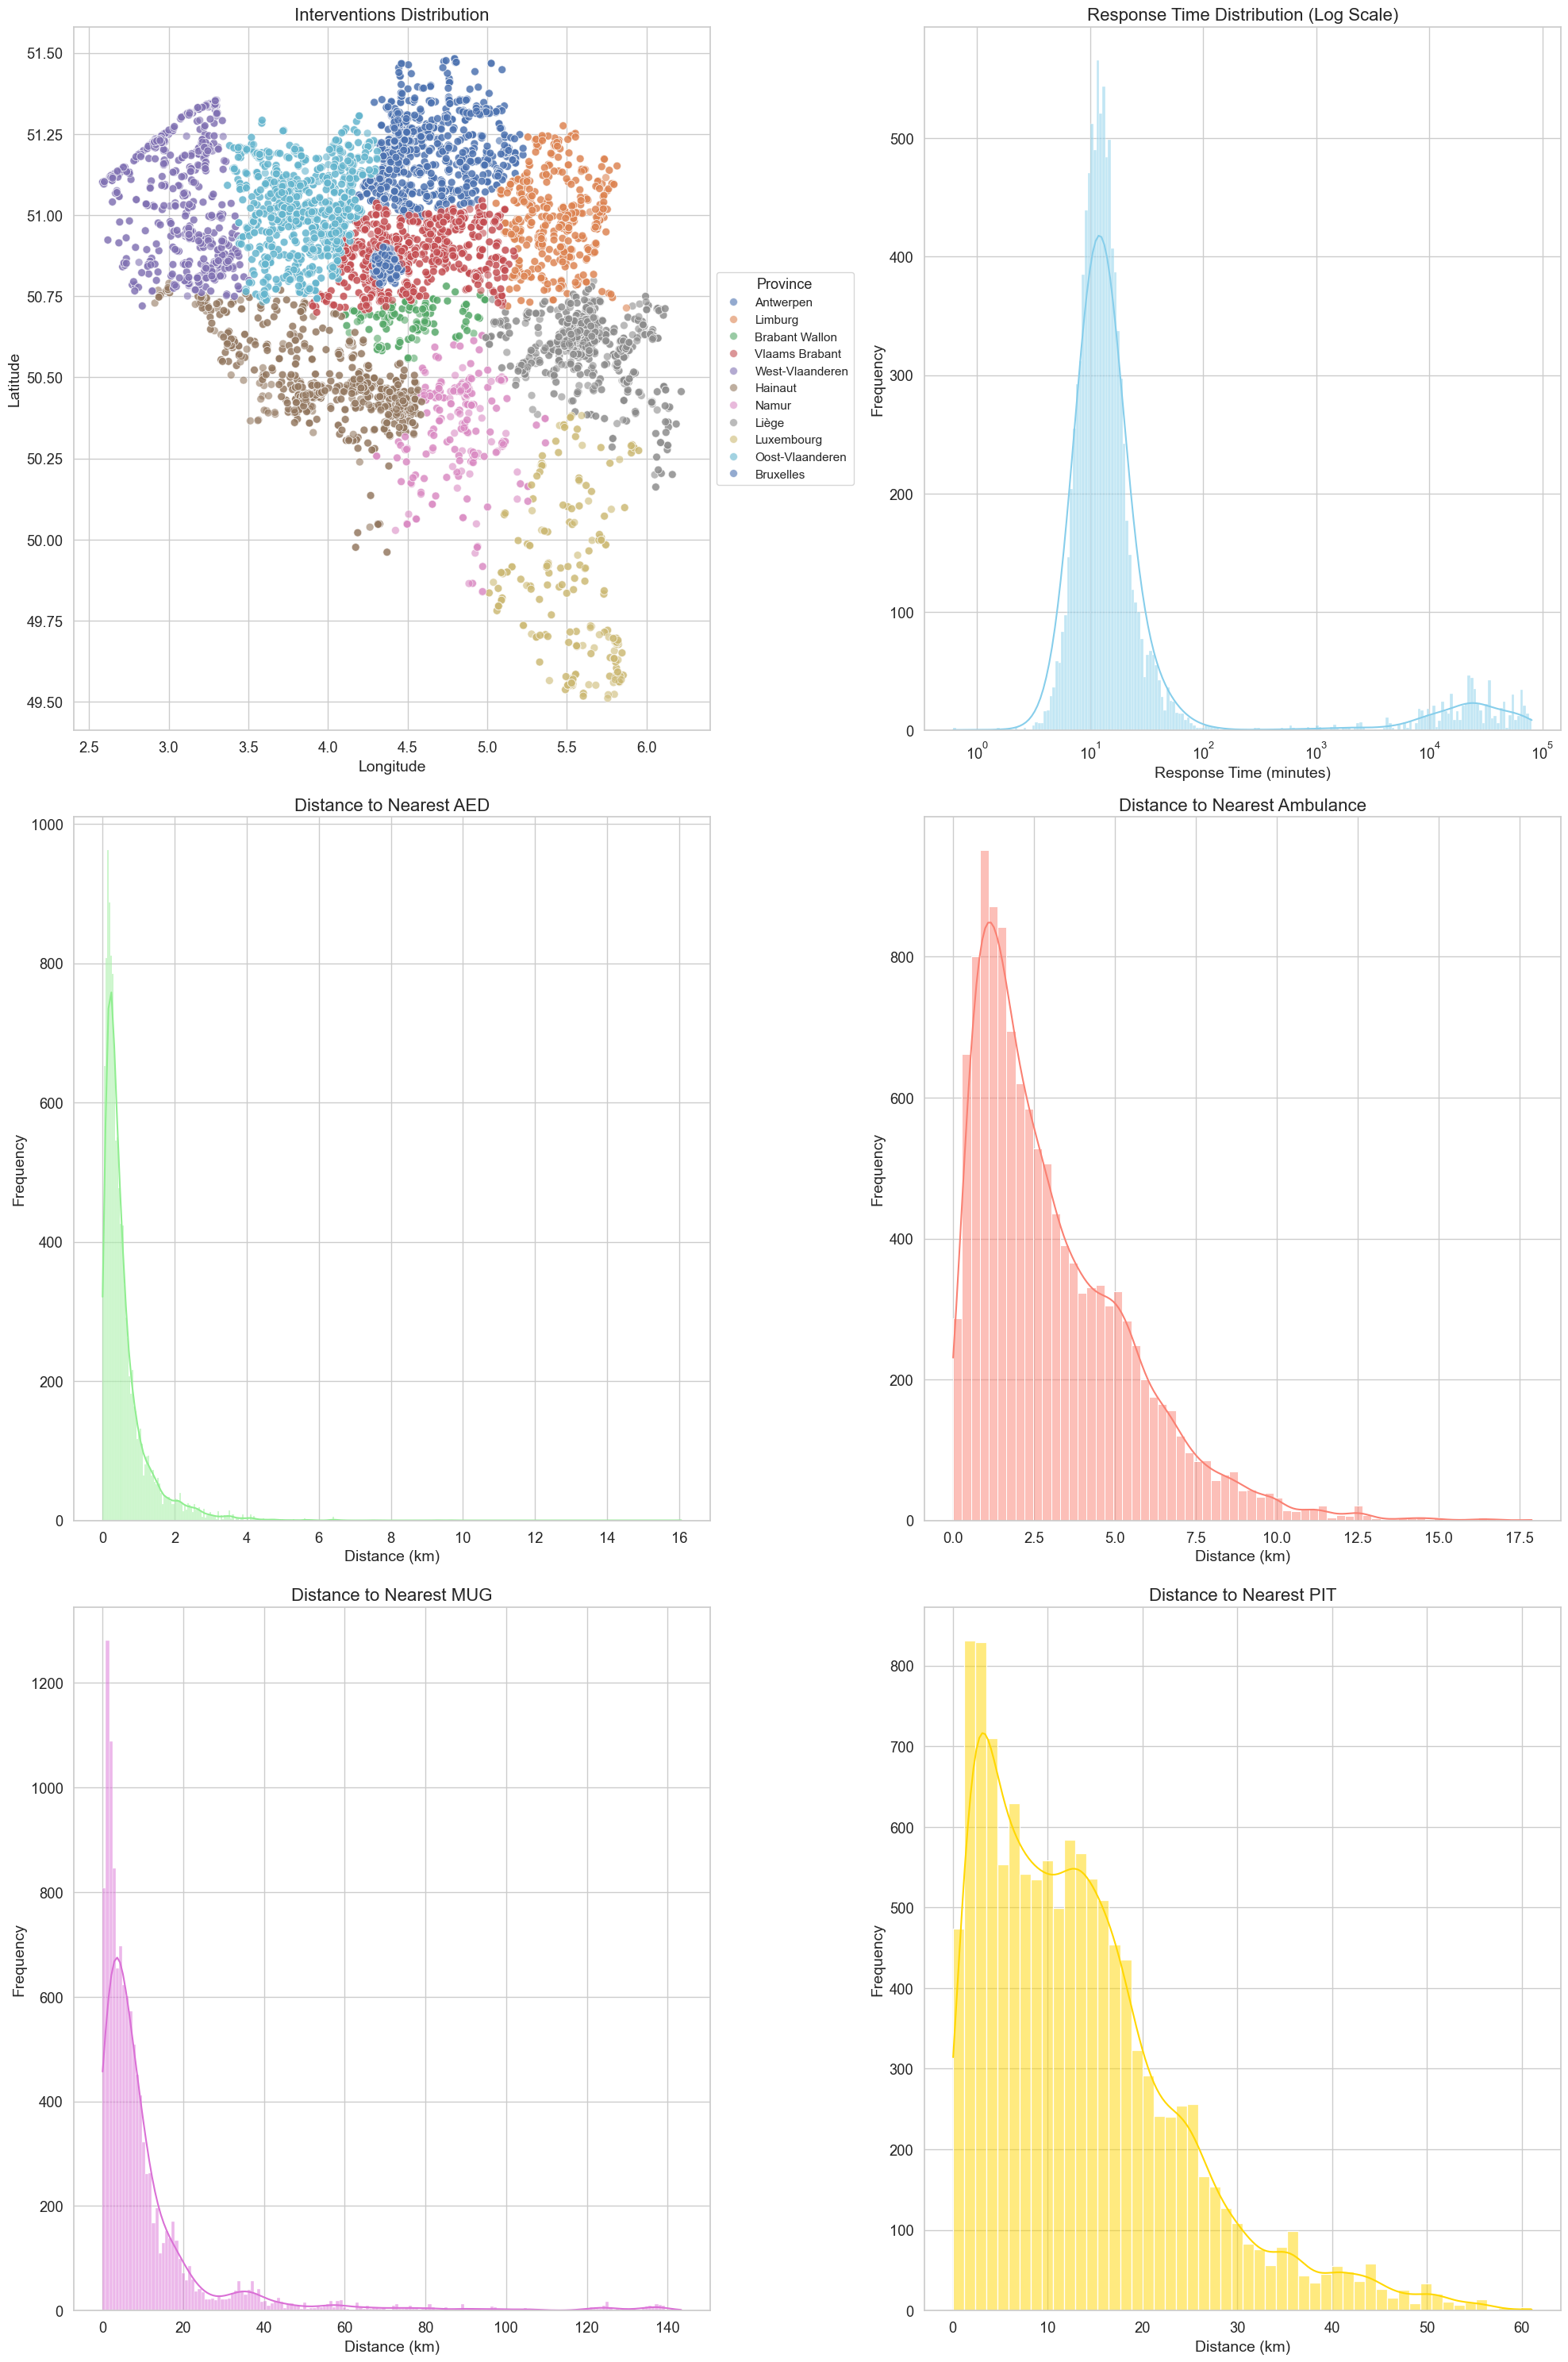

Data saved to /Users/Zhuanz/数字游民/mda 项目/mda_project/data/output/total_df_with_distances.csv


In [11]:
import pandas as pd
import geopandas as gpd
from scipy.spatial import KDTree
import numpy as np
from math import radians, cos, sin, asin, sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 30)

# Set paths
input_path = '/Users/Zhuanz/数字游民/mda 项目/mda_project/data/processed'
output_path = '/Users/Zhuanz/数字游民/mda 项目/mda_project/data/output'

# Load data
data = pd.read_csv(f'{input_path}/total_df.csv')
belgium_with_provinces_boundary = gpd.read_file(f'{input_path}/BELGIUM_-_Provinces.geojson')
belgium_with_provinces_boundary = belgium_with_provinces_boundary.to_crs(epsg=4326)

# Haversine formula
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers
    return c * r

def assign_province(df):
    geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    joined_gdf = gpd.sjoin(gdf, belgium_with_provinces_boundary, how="left", predicate="within")
    df['Province'] = joined_gdf['NAME_2']  
    return df

# Data preparation
data = data.dropna(subset=['Latitude', 'Longitude'])
data['distance_to_aed'] = np.inf
data['distance_to_ambulance'] = np.inf
data['distance_to_mug'] = np.inf
data['distance_to_pit'] = np.inf

aed_locations = data[data['AED'] == 1]
ambulance_locations = data[data['Ambulance'] == 1]
mug_locations = data[data['Mug'] == 1]
pit_locations = data[data['PIT'] == 1]
intervention_locations = data[data['Intervention'] == 1]

# Create KDTree objects
tree_aeds = KDTree(aed_locations[['Latitude', 'Longitude']])
tree_ambulances = KDTree(ambulance_locations[['Latitude', 'Longitude']])
tree_mugs = KDTree(mug_locations[['Latitude', 'Longitude']])
tree_pits = KDTree(pit_locations[['Latitude', 'Longitude']])

# Calculate distances
def calculate_distances(tree, locations, intervention_point):
    coords = intervention_point[['Latitude', 'Longitude']].values.reshape(1, -1)
    distance, index = tree.query(coords, k=1)
    if distance.size > 0 and index.size > 0:
        nearest = locations.iloc[index[0]]
        return haversine(intervention_point['Longitude'], intervention_point['Latitude'],
                         nearest['Longitude'], nearest['Latitude'])
    return np.inf

for idx, intervention_point in intervention_locations.iterrows():
    intervention_locations.at[idx, 'distance_to_aed'] = calculate_distances(tree_aeds, aed_locations, intervention_point)
    intervention_locations.at[idx, 'distance_to_ambulance'] = calculate_distances(tree_ambulances, ambulance_locations, intervention_point)
    intervention_locations.at[idx, 'distance_to_mug'] = calculate_distances(tree_mugs, mug_locations, intervention_point)
    intervention_locations.at[idx, 'distance_to_pit'] = calculate_distances(tree_pits, pit_locations, intervention_point)

# Combine datasets
result = pd.concat([intervention_locations, aed_locations, mug_locations, ambulance_locations, pit_locations], axis=0)
result.reset_index(drop=True, inplace=True)

# Visualization
sns.set(style="whitegrid", font_scale=1.2)

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(20, 30))

# Scatterplot of intervention coordinates
sns.scatterplot(data=intervention_locations, x='Longitude', y='Latitude', hue='Province', 
                palette='deep', alpha=0.6, s=50, ax=axes[0, 0])
axes[0, 0].set_title('Interventions Distribution', fontsize=16)
axes[0, 0].set_xlabel('Longitude', fontsize=14)
axes[0, 0].set_ylabel('Latitude', fontsize=14)
axes[0, 0].legend(title='Province', title_fontsize='13', fontsize='11', loc='center left', bbox_to_anchor=(1, 0.5))

# Response time distribution
sns.histplot(data=intervention_locations, x='T3-T0', kde=True, color='skyblue', 
             log_scale=True, ax=axes[0, 1])
axes[0, 1].set_title('Response Time Distribution (Log Scale)', fontsize=16)
axes[0, 1].set_xlabel('Response Time (minutes)', fontsize=14)
axes[0, 1].set_ylabel('Frequency', fontsize=14)

# Distance to nearest AED
sns.histplot(data=intervention_locations, x='distance_to_aed', kde=True, color='lightgreen', ax=axes[1, 0])
axes[1, 0].set_title('Distance to Nearest AED', fontsize=16)
axes[1, 0].set_xlabel('Distance (km)', fontsize=14)
axes[1, 0].set_ylabel('Frequency', fontsize=14)

# Distance to nearest Ambulance
sns.histplot(data=intervention_locations, x='distance_to_ambulance', kde=True, color='salmon', ax=axes[1, 1])
axes[1, 1].set_title('Distance to Nearest Ambulance', fontsize=16)
axes[1, 1].set_xlabel('Distance (km)', fontsize=14)
axes[1, 1].set_ylabel('Frequency', fontsize=14)

# Distance to nearest MUG
sns.histplot(data=intervention_locations, x='distance_to_mug', kde=True, color='orchid', ax=axes[2, 0])
axes[2, 0].set_title('Distance to Nearest MUG', fontsize=16)
axes[2, 0].set_xlabel('Distance (km)', fontsize=14)
axes[2, 0].set_ylabel('Frequency', fontsize=14)

# Distance to nearest PIT
sns.histplot(data=intervention_locations, x='distance_to_pit', kde=True, color='gold', ax=axes[2, 1])
axes[2, 1].set_title('Distance to Nearest PIT', fontsize=16)
axes[2, 1].set_xlabel('Distance (km)', fontsize=14)
axes[2, 1].set_ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()

# Save the processed data
result.to_csv(f'{output_path}/total_df_with_distances.csv', index=False)
print(f"Data saved to {output_path}/total_df_with_distances.csv")